In [1]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io as sio
from model.defeat_detect import DefeatDetectModel

In [2]:
model = DefeatDetectModel(32, 512, 64)
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

DefeatDetectModel(
  (wavelet): WaveletFeature(
    (lstm): LSTM(64, 32, num_layers=2, batch_first=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
  )
  (feature_merge): PurePhase()
  (backend): CnnBackend(
    (cbam1): CBAM(
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=32, out_features=2, bias=False)
        (1): ReLU()
        (2): Linear(in_features=2, out_features=32, bias=False)
      )
      (sigmoid): Sigmoid()
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kern

In [3]:
gridN = 512

start_idx = int(32 * 0)
val_len = 12

phases = []
truths = []
preds = []

for i in tqdm.tqdm(range(val_len)):
    mat = sio.loadmat('data/final_data_sim_{:04d}.mat'.format(start_idx + i))
    wave, phase = np.abs(mat['wave'][0]), mat['phase'][0]
    pred = model(torch.tensor(wave), torch.tensor(phase)).detach().numpy().squeeze()

    phases.append(np.mean(mat['phase'][0], axis=0))
    truths.append(mat['defeat'])
    preds.append(pred * gridN)

100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


In [4]:
print(truths[0])
print(preds[2])

from myloss import MyLoss

loss_fn = MyLoss(lambda_pos=1, lambda_rad=5, lambda_unpair=2)

losses = []
for i in range(val_len):
    loss = loss_fn(torch.tensor(preds[i] / gridN), torch.tensor(truths[i] / gridN))
    losses.append(loss.item())

print(losses)

[[231  40  17]
 [415 188  17]
 [264 365  11]]
[[348.62363   251.6665      9.909687  105.152084 ]
 [395.44803   255.85939     7.8620033  98.66499  ]
 [292.93948   189.06355    10.235313  103.167694 ]
 [389.97308    95.23379     8.59902   121.41552  ]
 [ 61.970573  157.10774     7.0642867  66.22097  ]
 [165.47725   123.59513     9.226219   56.8889   ]
 [185.97284   288.97824     7.541975   89.606865 ]
 [348.55524   378.83896     7.399355   86.85413  ]
 [190.7965    165.15906     5.252763   78.66479  ]
 [116.75948   272.30173     5.4403343 109.83447  ]
 [149.41869   177.13947     7.166345   84.28396  ]
 [208.36427   141.52843     9.358517   60.016945 ]
 [434.74802   173.69727    11.422892   63.60487  ]
 [369.51074   288.44144     9.269778  125.974075 ]
 [220.9308    417.55276     9.894292   87.564384 ]
 [234.85901   154.40123     5.1050363  79.434814 ]
 [316.25558   233.57285    11.644372   76.8814   ]
 [198.52939   272.34088     8.243895   90.90873  ]
 [314.29272   292.7441     14.501075

100%|██████████| 12/12 [00:00<00:00, 18.49it/s]


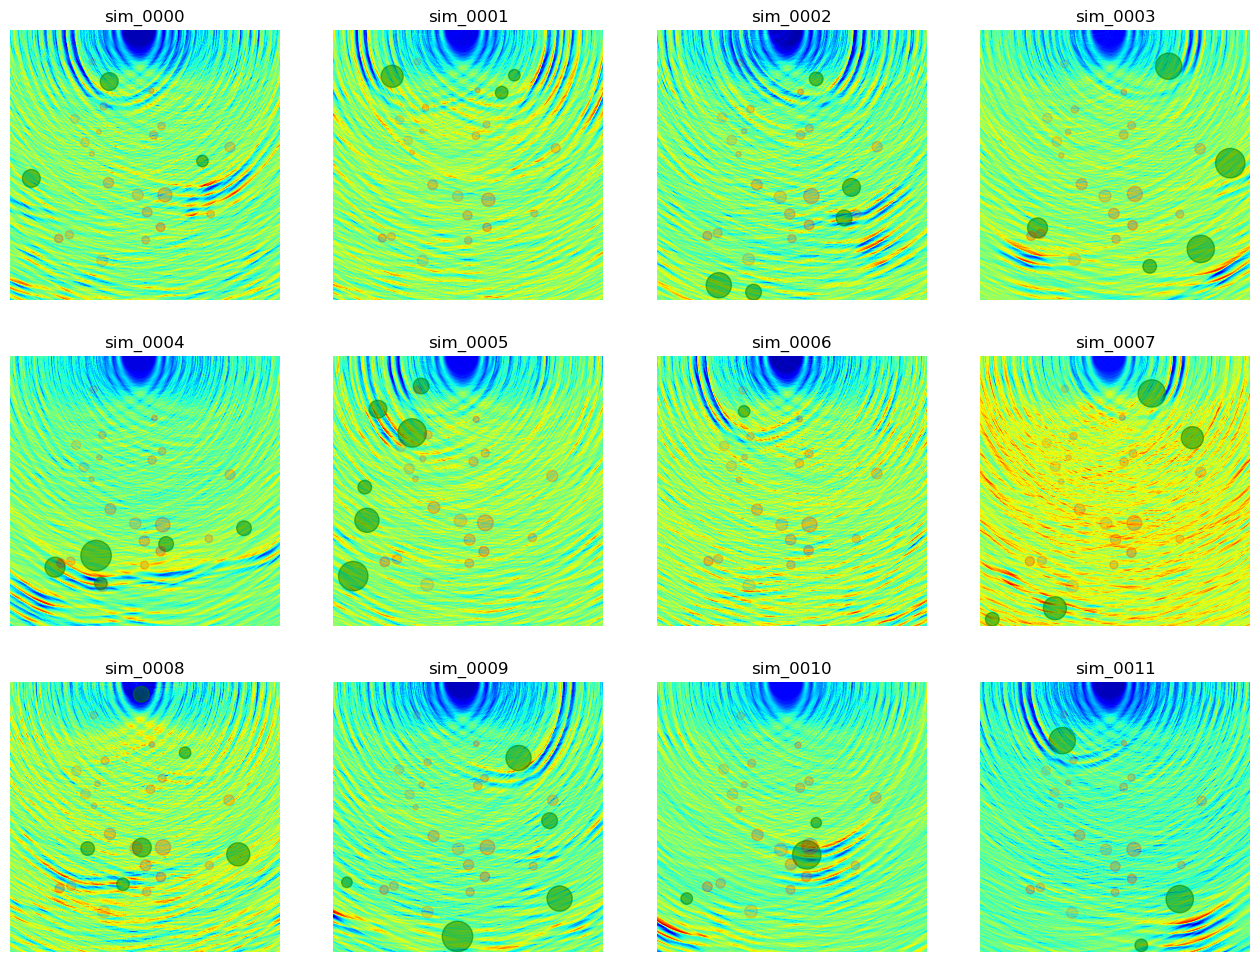

In [8]:
prob_threshold = 0

fig, ax = plt.subplots((val_len + 3) // 4, 4, figsize=(16, 4 * ((val_len + 3) // 4)))

for i in tqdm.tqdm(range(val_len)):

    ax[i // 4, i % 4].imshow(phases[i], cmap='jet')
    ax[i // 4, i % 4].set_title('sim_{:04d}'.format(start_idx + i))
    ax[i // 4, i % 4].axis('off')

    for defeat in truths[i]:
        x, y, r = defeat[0], defeat[1], defeat[2]
        ax[i // 4, i % 4].add_patch(patches.Circle((y, 512 - x), r, color='g', alpha=0.5))
    
    for defeat in preds[i]:
        if defeat[3] > prob_threshold * gridN:
            x, y, r, p = defeat[0], defeat[1], defeat[2], defeat[3]
            ax[i // 4, i % 4].add_patch(patches.Circle((y, x), r, color='r', alpha=p / gridN))